In [29]:
import pandas as pd 
from pathlib import Path 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 

DATA = Path("./data/")

df = pd.read_csv(DATA / "set.csv")

In [30]:
#train/test 
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

In [31]:
df_train = train.copy()

In [32]:
df_train.shape[0]

9600

In [33]:
#correlatin 

corr_matrix = df_train.corr(numeric_only=True)

corr_matrix['vo2max'].sort_values(ascending=False)

vo2max                    1.000000
max_pushups               0.613048
hdl_mg_dL                 0.585424
weekly_workouts           0.420761
steps_per_day             0.393636
bench_1rm_kg              0.350620
squat_1rm_kg              0.321723
protein_g                 0.311721
height_cm                 0.301631
sleep_hours               0.154212
calorie_intake            0.093511
weight_kg                -0.006587
id                       -0.015615
alcohol_units_per_week   -0.058134
triglycerides_mg_dL      -0.083731
smoker                   -0.205904
bmi                      -0.214783
stress_level             -0.233919
ldl_mg_dL                -0.564938
age                      -0.624012
diastolic_bp             -0.635157
systolic_bp              -0.678688
body_fat_pct             -0.716893
resting_hr               -0.751203
run_5k_min               -0.908321
Name: vo2max, dtype: float64

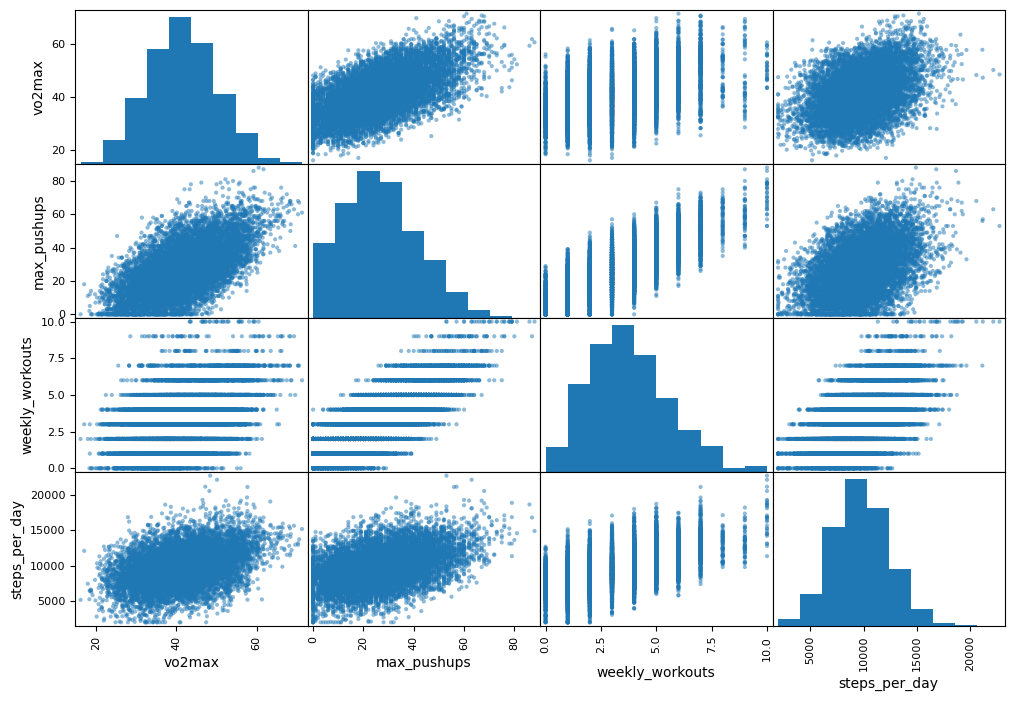

In [34]:
from pandas.plotting import scatter_matrix 

attributes = ["vo2max", "max_pushups","weekly_workouts", "steps_per_day"]
scatter_matrix(df_train[attributes], figsize=(12, 8))
plt.show()

In [35]:
#labels and the rest 

df_train = train.drop("vo2max", axis=1)
df_train_labels = train["vo2max"].copy()

In [36]:
#cleaning 

df_train.isna().sum()

id                        0
month                     0
age                       0
sex                       0
height_cm                 0
weight_kg                 0
bmi                       0
body_fat_pct              0
weekly_workouts           0
steps_per_day             0
sleep_hours               0
stress_level              0
calorie_intake            0
protein_g                 0
alcohol_units_per_week    0
smoker                    0
run_5k_min                0
resting_hr                0
systolic_bp               0
diastolic_bp              0
bench_1rm_kg              0
squat_1rm_kg              0
max_pushups               0
ldl_mg_dL                 0
hdl_mg_dL                 0
triglycerides_mg_dL       0
dtype: int64

In [37]:
#num data 
df_train_num = df_train.select_dtypes(include=[np.number])

In [38]:
#выбросы 
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(df_train_num)

In [39]:
outlier_pred 

array([ 1, -1,  1, ...,  1,  1,  1])

In [40]:
count_outlier = pd.DataFrame(outlier_pred, columns=["outlier_flag"], index=df_train_num.index)
count_outlier.value_counts()

outlier_flag
 1              8680
-1               920
Name: count, dtype: int64

In [41]:
df_train = df_train.iloc[outlier_pred == 1]
df_train_labels = df_train_labels.iloc[outlier_pred == 1]

Pipeline

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
#test with customs trans
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp, feature_names_out='one-to-one')



custom_pipeline = Pipeline([
    ('log', log_transformer)
])
# Автоматический выбор признаков по типу
numeric_features = make_column_selector(dtype_include='number')
categorical_features = make_column_selector(dtype_include='object')

# Пайплайн для числовых признаков
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Пайплайн для категориальных признаков
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


full_pipeline = make_pipeline(
    ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_features),
        ('categorical', categorical_pipeline, categorical_features),
        ('custom', custom_pipeline, ['calorie_intake'])
    ])
)


LinearRegression

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(full_pipeline, LinearRegression())
lin_reg.fit(df_train, df_train_labels)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000025ED12A0650>),
                                                                  ('categorical',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy=...frequent')),
                                                                                   ('encoder',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x0000025ED12A15B0>),
                                                                  ('custom',
                                                                   Pipeline(steps=[('log',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log'>,
                                                                                                        inverse_func=<ufunc 'exp'>))]),
                                                                   ['calorie_intake'])]))])),
                ('linearregression', LinearRegression())])

In [44]:
predictions = lin_reg.predict(df_train)

In [45]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, predictions, squared=False)

lin_rmse = root_mean_squared_error(df_train_labels, predictions)
lin_mae = mean_absolute_error(df_train_labels, predictions)

In [46]:
print(f"RMSE: {lin_rmse}")
print(f"MAE: {lin_rmse}")

RMSE: 1.6985537643971542
MAE: 1.6985537643971542


In [47]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(lin_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(lin_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Средний RMSE:", lin_rmses.mean())
print("Средний MAE:", lin_maes.mean())

Средний RMSE: 1.7059403663249295
Средний MAE: 1.3556447452461509


RandomForestRegressor

In [48]:
from sklearn.ensemble import RandomForestRegressor

# создаём пайплайн: препроцессинг + случайный лес
rf_reg = make_pipeline(
    full_pipeline,
    RandomForestRegressor(
        n_estimators=200,      # количество деревьев
        max_depth=5,        # глубина деревьев (None = до упора)
        min_samples_split=5,
        min_samples_leaf=3,
        random_state=42,
        max_features='sqrt',
        n_jobs=-1              # использовать все ядра процессора
    )
)

# обучение на тренировочных данных
rf_reg.fit(df_train, df_train_labels)

# предсказания
forest_predictions = rf_reg.predict(df_train)

In [49]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, forest_predictions, squared=False)

rf_rmse = root_mean_squared_error(df_train_labels, forest_predictions)
rf_mae = mean_absolute_error(df_train_labels, forest_predictions)

print(f"RMSE: {rf_rmse}")
print(f"MAE: {rf_rmse}")

RMSE: 2.784044429741683
MAE: 2.784044429741683


In [50]:
#cross-valid 
from sklearn.model_selection import cross_val_score

lin_rmses = -cross_val_score(rf_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
lin_maes = -cross_val_score(rf_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Средний RMSE:", lin_rmses.mean())
print("Средний MAE:", lin_maes.mean())

Средний RMSE: 2.8723763042831356
Средний MAE: 2.2416885458027793


XGBoost

In [51]:
from xgboost import XGBRegressor

# пайплайн: препроцессинг + XGBoost
xgb_reg = make_pipeline(
    full_pipeline,
    XGBRegressor(
        n_estimators=1000,      # количество деревьев (итераций бустинга)
        learning_rate=0.05,    # скорость обучения
        max_depth=4,           # глубина деревьев
        subsample=0.8,         # доля данных для каждого дерева
        colsample_bytree=0.8,  # доля признаков для каждого дерева
        gamma = 0.5,
        min_child_weight = 5,
        random_state=42,
        n_jobs=-1
    )
)

# обучение
xgb_reg.fit(df_train, df_train_labels)

# предсказания
xgb_predictions = xgb_reg.predict(df_train)

In [52]:
from sklearn.metrics import mean_absolute_error

try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error

    def root_mean_squared_error(labels, predictions):
        return mean_squared_error(labels, xgb_predictions, squared=False)

xgb_rmse = root_mean_squared_error(df_train_labels, xgb_predictions)
xgb_mae = mean_absolute_error(df_train_labels, xgb_predictions)

print(f"RMSE: {xgb_rmse}")
print(f"MAE: {xgb_rmse}")

RMSE: 1.1876826780413592
MAE: 1.1876826780413592


In [53]:
#cross-valid 
from sklearn.model_selection import cross_val_score

xgb_rmses = -cross_val_score(xgb_reg, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
xgb_maes = -cross_val_score(xgb_reg, df_train, df_train_labels,
                            scoring='neg_mean_absolute_error', cv=10)

print("Средний RMSE:", xgb_rmses.mean())
print("Средний MAE:", xgb_maes.mean())

Средний RMSE: 1.7869663333921295
Средний MAE: 1.4230003024246287


Настройки гиперпараметров лучшей модели

In [54]:
entire_pipeline = Pipeline([
    ("preprocessing", full_pipeline),
    ("linear_regression", LinearRegression()),
])

#witch params there are
print(str(entire_pipeline.get_params().keys())[:1000] + "...")

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'linear_regression', 'preprocessing__memory', 'preprocessing__steps', 'preprocessing__verbose', 'preprocessing__columntransformer', 'preprocessing__columntransformer__force_int_remainder_cols', 'preprocessing__columntransformer__n_jobs', 'preprocessing__columntransformer__remainder', 'preprocessing__columntransformer__sparse_threshold', 'preprocessing__columntransformer__transformer_weights', 'preprocessing__columntransformer__transformers', 'preprocessing__columntransformer__verbose', 'preprocessing__columntransformer__verbose_feature_names_out', 'preprocessing__columntransformer__numeric', 'preprocessing__columntransformer__categorical', 'preprocessing__columntransformer__custom', 'preprocessing__columntransformer__numeric__memory', 'preprocessing__columntransformer__numeric__steps', 'preprocessing__columntransformer__numeric__verbose', 'preprocessing__columntransformer__numeric__imputer', 'preprocessing__columntransformer__nu

In [55]:
#random research 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
    'preprocessing__columntransformer__remainder': ['drop', 'passthrough'],
    'preprocessing__columntransformer__sparse_threshold': [0.0, 0.3, 0.5, 1.0],
    'linear_regression__fit_intercept': [True, False]
}

rnd_search = RandomizedSearchCV(
    entire_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(df_train, df_train_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(transformers=[('numeric',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                <sklearn.compose._column_transformer.make_column_selector object at 0x0000025ED12A0650>),
                                                                                               ('categorical',
                                                                                                Pipeline(st...
                                                                                                                                     inverse_func=<ufunc 'exp'>))]),
                                                                                                ['calorie_intake'])]))])),
                                             ('linear_regression',
                                              LinearRegression())]),
                   param_distributions={'linear_regression__fit_intercept': [True,
                                                                             False],
                                        'preprocessing__columntransformer__remainder': ['drop',
                                                                                        'passthrough'],
                                        'preprocessing__columntransformer__sparse_threshold': [0.0,
                                                                                               0.3,
                                                                                               0.5,
                                                                                               1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [56]:
rnd_search.best_params_

{'preprocessing__columntransformer__sparse_threshold': 0.0,
 'preprocessing__columntransformer__remainder': 'drop',
 'linear_regression__fit_intercept': True}

In [57]:
best_model = rnd_search.best_estimator_
predictions = best_model.predict(df_train)

In [58]:
best_rmses = -cross_val_score(best_model, df_train, df_train_labels,
                              scoring="neg_root_mean_squared_error", cv=10)
pd.Series(best_rmses).describe()

count    10.000000
mean      1.705940
std       0.042499
min       1.618043
25%       1.675514
50%       1.727001
75%       1.732025
max       1.753154
dtype: float64

In [59]:
final_model = rnd_search.best_estimator_

# коэффициенты линейной регрессии
coefs = final_model["linear_regression"].coef_

# имена признаков после препроцессинга
feature_names = final_model["preprocessing"].get_feature_names_out()

# объединяем в таблицу
import pandas as pd
importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
}).sort_values(by="coefficient", key=abs, ascending=False)
print(importance_df.head(10))


                     feature  coefficient
14       numeric__run_5k_min    -5.236158
5      numeric__body_fat_pct    -1.888099
1               numeric__age    -1.379464
7     numeric__steps_per_day    -1.212149
15       numeric__resting_hr    -0.975144
6   numeric__weekly_workouts     0.779967
3         numeric__weight_kg    -0.436010
13           numeric__smoker     0.435175
4               numeric__bmi     0.326112
2         numeric__height_cm     0.255113


Test probe

In [60]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

X_test = test.drop("vo2max", axis=1)
y_test = test["vo2max"].copy()

final_predictions = final_model.predict(X_test)

# === Метрики ===
final_rmse = root_mean_squared_error(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)

print(f"RMSE: {final_rmse:.2f}")
print(f"MAE:  {final_mae:.2f}")


RMSE: 1.75
MAE:  1.38


Visualisation

In [1]:
# y_test и y_pred — это реальные и предсказанные значения
y_pred = final_predictions

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Идеальное совпадение')
plt.xlabel("Реальные значения (y_test)")
plt.ylabel("Предсказанные значения (y_pred)")
plt.title("Predicted vs Actual")
plt.legend()
plt.savefig("out/img/Predicted vs Actual.png", dpi=300)
plt.show()

NameError: name 'final_predictions' is not defined

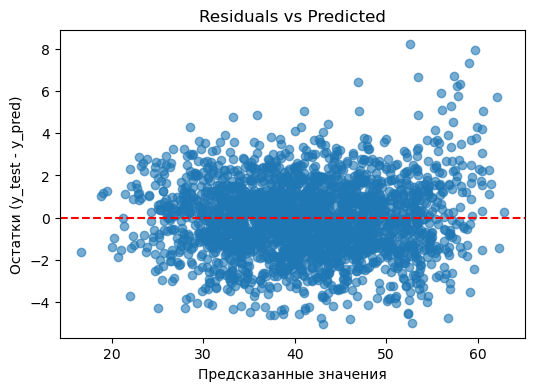

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Предсказанные значения")
plt.ylabel("Остатки (y_test - y_pred)")
plt.title("Residuals vs Predicted")
plt.savefig("out/img/Residuals vs Predicted.png", dpi=300)
plt.show()


Save

In [ ]:
import joblib
joblib.dump(final_model, "out/models/linear_vo2max.pkl")

['out/linear_vo2max.pkl']